In [59]:
from pathlib import Path
import torchio as tio
from collections import defaultdict
from PIL import Image
import numpy as np

# Process all

In [68]:
def compute_dice(pred, target):
    pred = pred > 0
    target = target > 0
    intersection = (pred & target).sum()
    dice = 2 * intersection / (pred.sum() + target.sum())
    return dice

label_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/labelsTs')
label_volumes = list(label_dir.glob('*.nii.gz'))
label_volumes.sort()

for fold in range(3):
    prediction_dir = Path('/storage_bizon/naravich/radio_predictions')
    prediction_fold0 = prediction_dir / f'test_fold{fold}'
    prediction_images = list(prediction_fold0.glob('*.png'))
    prediction_images.sort()


    volumes = defaultdict(list)
    for image_path in prediction_images:
        volume = image_path.stem.split('_')[0]
        volumes[volume].append(image_path)

    for volume in volumes.keys():
        D3_images = volumes[volume]
        D3_images.sort()
        D3_images = [np.array(Image.open(image_path)) for image_path in D3_images]
        D3_images = np.stack(D3_images, axis=0)
        volumes[volume] = D3_images[np.newaxis, ...].transpose(0, 2, 3, 1)

    dices = []
    subject = tio.Subject(
        **{volume: tio.LabelMap(tensor=tensor) for volume, tensor in volumes.items()},
        **{f'label_{volume}': tio.LabelMap(path) for volume, path in zip(volumes.keys(), label_volumes)}
    )
    for volume in volumes.keys():
        dice = compute_dice(subject[volume].data, subject[f'label_{volume}'].data)
        print(f'{volume}: {dice:.5f}')
        dices.append(dice)

    print(f'Fold {fold} Mean dice: {np.mean(dices)}')

101-045: 0.41985
706-005: 0.66928
Fold 0 Mean dice: 0.5445629954338074
101-045: 0.42646
706-005: 0.65161
Fold 1 Mean dice: 0.5390350818634033
101-045: 0.37177
706-005: 0.65845
Fold 2 Mean dice: 0.5151075124740601


# Step by step

In [60]:
prediction_dir = Path('/storage_bizon/naravich/radio_predictions')
prediction_fold0 = prediction_dir / 'test_fold0'
prediction_images = list(prediction_fold0.glob('*.png'))
prediction_images.sort()

label_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/labelsTs')
label_volumes = list(label_dir.glob('*.nii.gz'))
label_volumes.sort()

In [62]:
volumes = defaultdict(list)

for image_path in prediction_images:
    volume = image_path.stem.split('_')[0]
    volumes[volume].append(image_path)

In [63]:
for volume in volumes.keys():
    D3_images = volumes[volume]
    D3_images.sort()
    D3_images = [np.array(Image.open(image_path)) for image_path in D3_images]
    D3_images = np.stack(D3_images, axis=0)
    volumes[volume] = D3_images[np.newaxis, ...].transpose(0, 2, 3, 1)

    print(volumes[volume].shape)


(1, 500, 500, 375)
(1, 500, 500, 375)


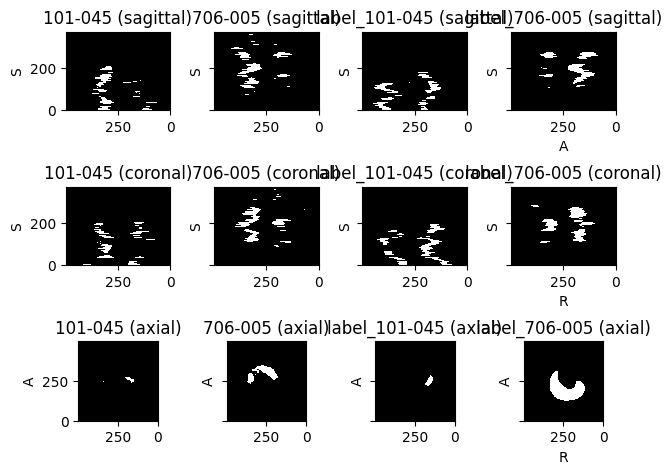

In [64]:
subject = tio.Subject(
    **{volume: tio.LabelMap(tensor=tensor) for volume, tensor in volumes.items()},
    **{f'label_{volume}': tio.LabelMap(path) for volume, path in zip(volumes.keys(), label_volumes)}
)
subject.plot()

In [65]:
def compute_dice(pred, target):
    pred = pred > 0
    target = target > 0
    intersection = (pred & target).sum()
    dice = 2 * intersection / (pred.sum() + target.sum())
    return dice

In [66]:
dices = []
for volume in volumes.keys():
    dice = compute_dice(subject[volume].data, subject[f'label_{volume}'].data)
    print(f'{volume}: {dice:.5f}')
    dices.append(dice)

print(f'Mean dice: {np.mean(dices)}')

101-045: 0.41985
706-005: 0.66928
Mean dice: 0.5445629954338074
